In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import helpers.fileload as fl
from helpers.calc_chemfeat import perovskite
from pypif import pif
from pypif.obj import *
import copy
from citrination_client import CitrinationClient

In [22]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/conductivity') #data/EIS_data
pifdir = os.path.join(datadir,'pifs')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

In [86]:
src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':'dry'})
    fl.get_formula(df,overwrite=True)

    outfile = os.path.join(pifdir,'{}_pif.json'.format(sample))
    file = open(outfile,'w')
    oxavg_pifs = []

    for idx in df.index:
        row = df.loc[idx,:]
        if row['Sigma_elec'] > 0:
            row_pif = ChemicalSystem()
            "Identifiers"
            sample_num = Id(name='Sample', value=sample[-5:])
            point = Id(name='Point',value=int(row['Point'])) #multipart index (point,formula)
            row_pif.ids = [sample_num, point]
            "Formula"
            row_pif.chemical_formula = row['formula'] #multipart index (point,formula)
            "Properties"
            #output properties - "labels"
            sigma = Property(name='$\sigma_{elec}$',units='S/cm',scalars=row['Sigma_elec'])
            sigma.conditions = [Value(name='Temperature ($^\circ$C)',scalars=int(row['Temp_C'])),
                                Value(name='Atmosphere',scalars=row['atm'])]
            props = [sigma]
            #input propertes - "features"
            pvskt = perovskite(formula=row['formula'], site_ox_lim={'A':[2,4],'B':[3,4]},site_base_ox={'A':2,'B':4})
            pvskt.set_cat_ox_lim('Co',[2,3])
            pvskt.featurize()
            props_oxavg = props.copy()
            #filtered_feat = {k:v for (k,v) in pvskt.features.items() if k[-5:] not in ['oxmin','oxmax']}
            for feat, val in pvskt.features.items():
                prop = Property(name=feat,scalars=val)
                props.append(prop)
                if feat[-5:] not in ['oxmin','oxmax'] and feat[0:7]!='O_delta':
                    props_oxavg.append(prop)
            row_pif_oxavg = copy.copy(row_pif)
            row_pif.properties = props
            row_pif_oxavg.properties = props_oxavg
            oxavg_pifs.append(row_pif_oxavg)
            pif.dump(row_pif,file)

    file.close()    
    print('Dumped {} pifs in {}'.format(len(df), os.path.basename(outfile)))

    oxavg_outfile = os.path.join(pifdir,'{}_oxavg_pif.json'.format(sample))
    oxavg_file = open(oxavg_outfile,'w')
    for rp in oxavg_pifs:
        pif.dump(rp,oxavg_file)
    oxavg_file.close()
    print('Dumped {} pifs in {}'.format(len(oxavg_pifs), os.path.basename(oxavg_outfile)))


Dumped 132 pifs in PDAC_COM3_01251_pif.json
Dumped 130 pifs in PDAC_COM3_01251_oxavg_pif.json
Dumped 132 pifs in PDAC_COM3_01254_pif.json
Dumped 132 pifs in PDAC_COM3_01254_oxavg_pif.json
Dumped 132 pifs in PDAC_COM3_01255_pif.json
Dumped 131 pifs in PDAC_COM3_01255_oxavg_pif.json
Dumped 132 pifs in PDAC_COM3_01256_pif.json
Dumped 131 pifs in PDAC_COM3_01256_oxavg_pif.json


In [54]:
"create dataset if not existing"
# client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')
# dataset = client.create_dataset(name='tco_sigma_elec_full',
#                                 description='Electrical conductivity for TCO thin films with all features',
#                                 public=0)

# dataset2 = client.create_dataset(name='tco_sigma_elec_oxavg',
#                                 description='Electrical conductivity for TCO thin films with oxavg features only',
#                                 public=0)

# dataset.id, dataset2.id

(162724, 162725)

In [87]:
"Upload pifs"
client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')
dsid1 = 162724 #full
dsid2 = 162725 #oxavg only

results1 = []
results2 = []

for file in glob.glob(os.path.join(pifdir,'*.json')):
    filename = os.path.basename(file)
    if file.find('oxavg') >= 0:
        result = client.upload(dsid2,file)
        results2.append(result)
        #print('oxavg: {}'.format(filename))
    else:
        result = client.upload(dsid1,file)
        results1.append(result)
        #print('full: ' + filename)
        
[r.__dict__ for r in results1], [r.__dict__ for r in results2]

([{'_failures': [],
   '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/conductivity\\pifs\\PDAC_COM3_01251_pif.json'}]},
  {'_failures': [],
   '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/conductivity\\pifs\\PDAC_COM3_01254_pif.json'}]},
  {'_failures': [],
   '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/conductivity\\pifs\\PDAC_COM3_01255_pif.json'}]},
  {'_failures': [],
   '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/conductivity\\pifs\\PDAC_COM3_01256_pif.json'}]}],
 [{'_failures': [],
   '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/conductivity\\pifs\\PDAC_COM3_01251_oxavg_pif.json'}]},
  {'_failures': [],
   '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado Schoo

In [97]:
"dataset excluding 01255"
dataset3 = client.create_dataset(name='tco_sigma_elec_excl01255',
                                description='Electrical conductivity for TCO thin films with oxavg features only and 01255 excluded',
                                public=0)
dataset3.id

162726

In [100]:
"Upload pifs to dataset 3"
dsid3 = 162726 #oxavg only, exclude 01255

results3 = []

for file in glob.glob(os.path.join(pifdir,'*.json')):
    filename = os.path.basename(file)
    if file.find('oxavg') >= 0 and file.find('01255')==-1:
        result = client.upload(dsid3,file)
        results3.append(result)
        print(filename)
        
[r.__dict__ for r in results3]

PDAC_COM3_01251_oxavg_pif.json
PDAC_COM3_01254_oxavg_pif.json
PDAC_COM3_01256_oxavg_pif.json


[{'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/conductivity\\pifs\\PDAC_COM3_01251_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/conductivity\\pifs\\PDAC_COM3_01254_oxavg_pif.json'}]},
 {'_failures': [],
  '_successes': [{'path': 'C:\\Users\\jdhuang\\OneDrive - Colorado School of Mines/Research/MIDDMI/TCO\\data/conductivity\\pifs\\PDAC_COM3_01256_oxavg_pif.json'}]}]

In [90]:
data = pd.DataFrame()
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':'dry'})
    df['sample'] = sample
    data = data.append(df,sort=True)
    
neg = data.loc[data['Sigma_elec']<=0,:]
pos = data.loc[data['Sigma_elec']>=0,:]


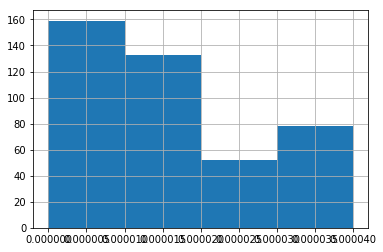

In [85]:
bins = np.arange(0,5e-5,1e-5)
pos['Sigma_elec'].hist(bins=bins)

In [96]:
low = data.loc[data['Sigma_elec']<5e-6,:]
for s in low['sample'].unique():
    print(s,len(low[low['sample']==s]))

PDAC_COM3_01251 3
PDAC_COM3_01254 22
PDAC_COM3_01255 131
PDAC_COM3_01256 1
